<div class="alert alert-block alert-danger">

### Random reference notes 

</div>

### Bayesian statistics, Pymc3, $ \ldots $.

#### Bayes

Let $ \mathbf{x} \in \mathbb{R}^{n}$ and $ \theta $ from some distribution.

\begin{align}
P( \theta \mid \mathbf{x}) &= \frac{P(\mathbf{x} \mid \theta)P(\theta)}{P(\mathbf{x})} \\
&\propto P(\mathbf{x} \mid \theta) P(\theta)
\end{align}

<hr/>

\begin{align}
P( \theta \mid \mathbf{x}) &= \frac{P(\theta, \mathbf{x})}{P(\mathbf{x}} \\
&= \frac{P(\mathbf{x} \mid \theta)P(\theta)}{P(\mathbf{x})} \\
or \\
\end{align}

\begin{align}
P(\theta, \mathbf{x}) &= P( \theta \mid \mathbf{x}) P(\mathbf{x}) \\
P(\theta, \mathbf{x}) &= P( \mathbf{x} \mid \theta) P(\theta) \\
P( \theta \mid \mathbf{x}) P(\mathbf{x}) &= P( \mathbf{x} \mid \theta) P(\theta) \\
P( \theta \mid \mathbf{x}) &= \frac{P(\mathbf{x} \mid \theta)P(\theta)}{P(\mathbf{x})} \\
\end{align}

<hr/>

#### Conjugate Priors

If the posterior $P( \theta \mid \mathbf{x})$ and the prior $P(\theta)$ belong to the same family of distributions, then $P(\theta)$ is the conjugate prior for the likelihood $P(\mathbf{x} \mid \theta)$ and the prior and posterior are conjugate distributions.

In [61]:
%matplotlib inline

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

from scipy import stats

In [63]:
np.random.seed(1234)

<hr/>

- Number of heads in $n$ independent tosses of a biased coin as $lim_{n\to\infty}$
- beta distribution is the known conjugate prior for the binomial distribution

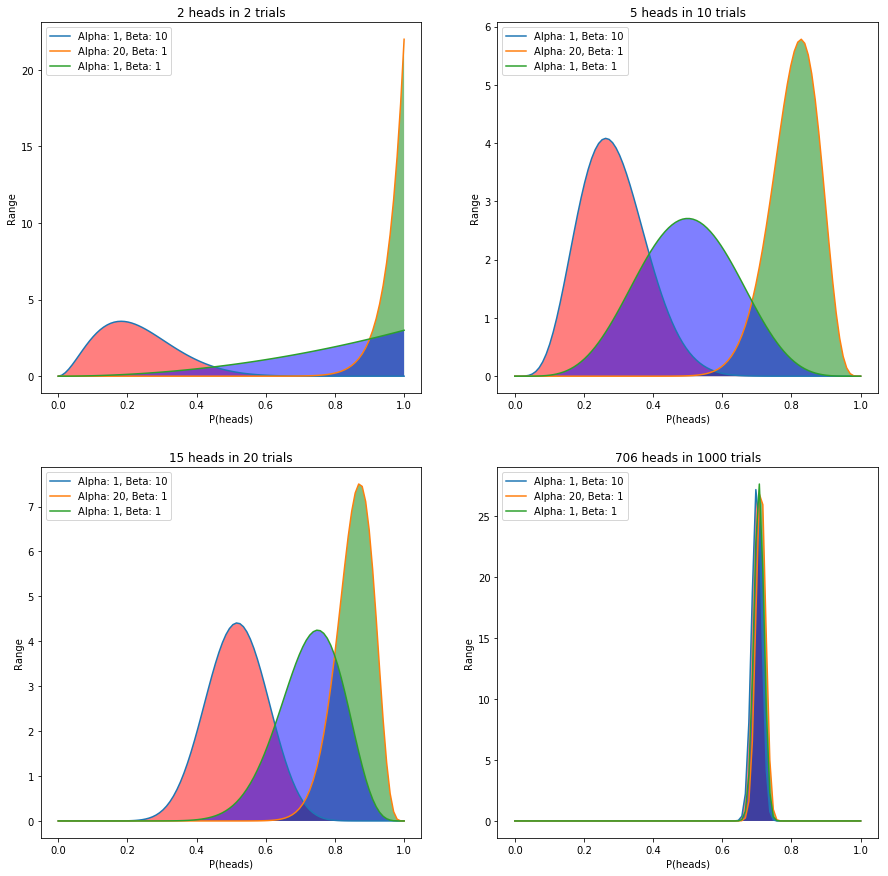

In [60]:
prob_biased_coin = 0.7

n_samples = [2, 10, 20, 1000]

domain = np.linspace(0, 1, 100)

hypothesized_alphas_betas = [(1, 10, 'r'), (20, 1, 'g'), (1, 1, 'b')]

plt.figure(figsize=(15,15))

for i, N in enumerate(n_samples):
    
    num_heads = stats.binom.rvs(N, prob_biased_coin, size=1)
    plt.subplot(len(n_samples)>>1, 2, i+1)
    
    for param in hypothesized_alphas_betas:
        
        alpha, beta, color = param
        range = stats.beta.pdf(domain, num_heads + alpha, N - num_heads + beta)
        plt.plot(domain, range, label='Alpha: '+str(alpha)+', Beta: '+str(beta))
        plt.fill_between(domain, 0, range, facecolor=color, alpha=0.5)
    
    plt.xlabel('P(heads)')
    plt.ylabel('Range')
    plt.legend()
    plt.title('{} heads in {} trials'.format(*num_heads, N));

WTS: If $X \sim \text{binomial}(n, \theta)$ and the prior $\theta \sim \text{beta}(\alpha, \beta)$, then the posterior $\sim \text{beta}(x+\alpha, n-x+\beta)$

\begin{align}
p(x \mid \theta) = \binom{n}{x} \theta^x (1-\theta)^{n-x} \\
\end{align}

\begin{align}
p(\theta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \theta^{\alpha - 1} (1-\theta)^{\beta -1}, \theta \in (0,1) \\
\end{align}

\begin{align}
p(x, \theta) &= p(x \mid \theta) p(\theta) \\
&= \binom{n}{x} \theta^x (1-\theta)^{n-x} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \theta^{\alpha - 1} (1-\theta)^{\beta -1} \\
&= \binom{n}{x} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \theta^{x+\alpha-1} (1-\theta)^{n-x+\beta-1}
\end{align}

\begin{align}
p(x) &= \int^1_0 p(x, \theta) d\theta \\
&= \binom{n}{x} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \int^1_0 \theta^{x+\alpha-1} (1-\theta)^{n-x+\beta-1} d\theta \\
&= \binom{n}{x} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(x+\alpha)\Gamma(n-x+\beta)}{\Gamma(n+\alpha+\beta)} \int^1_0 \frac{\Gamma(x+\alpha)\Gamma(n-x+\beta)}{\Gamma(n+\alpha+\beta)} \theta^{x+\alpha-1} (1-\theta)^{n-x+\beta-1} d\theta \\
&= \binom{n}{x} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(x+\alpha)\Gamma(n-x+\beta)}{\Gamma(n+\alpha+\beta)}
\end{align}

\begin{align}
p(\theta \mid x) &= \frac{p(x, \theta)}{p(x)} \\
&= \frac{\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}}{\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}} \frac{\theta^{x+\alpha-1} (1-\theta)^{n-x+\beta-1}}{\frac{\Gamma(x+\alpha)\Gamma(n-x+\beta)}{\Gamma(n+\alpha+\beta)}} \\
&= \frac{\Gamma(n+\alpha+\beta)}{\Gamma(x+\alpha)\Gamma(n-x+\beta)} \theta^{x+\alpha-1} (1-\theta)^{n-x+\beta-1} \\
&\sim beta(x+\alpha, n-x+\beta)
\end{align}

<div class="alert alert-block alert-info">
    
Pymc3

</div>

<hr/>

- Number of heads in $n$ independent tosses of a biased coin

In [70]:
prob_biased_coin = 0.7

num_coins_tosses = 10

num_samples = 1000

data = stats.binom.rvs(n=num_coins_tosses, p=prob_biased_coin, size=num_samples)

alpha, beta = np.random.randint(0, 10, 2)

with pm.Model() as biased_coin_model:

    theta = pm.Beta('theta', alpha=alpha, beta=beta)
    x = pm.Binomial('x', n=num_coins_tosses, p=theta, observed=data)
    trace = pm.sample(1000, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains: 100%|██████████████| 3000/3000 [00:03<00:00, 1099.03draws/s]


In [71]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.700747,0.004696,0.000186,0.69112,0.709614,549.030137,0.999676


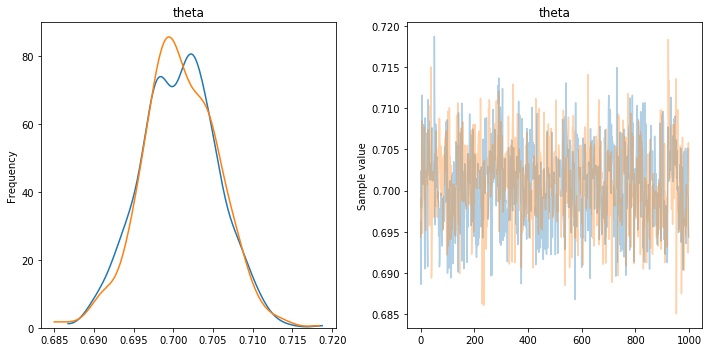

In [72]:
pm.traceplot(trace, figsize=(10,5));

<div class="alert alert-block alert-info">

Markov chain Monte Carlo sampling methods

- Metropolis–Hastings
- Gibbs sampling
    
</div>